In [2]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(VennDiagram))
suppressPackageStartupMessages(library(qvalue))
options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
fold_cl <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/"
file_cl <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData"
fold <- "OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/"
filt_path_file <- "pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData"
outFold <- sprintf('%sCAD_clustering/', fold_notebook)
colorFile <- sprintf('%scolor_pheno_type_UKBB.txt', fold_notebook)

cl <- get(load(file_cl))
n_gr <- length(unique(cl$cl_best$gr))
tscore_gr <- list()
pathR_gr <- list()
pathGO_gr <- list()
path_gr <- list()

for(i in 1:n_gr){
    tscore_gr[[i]] <- read.table(sprintf('%scluster_specific_PALAS/tscore_pval_ClusterCasesVSControls_gr%i.txt', fold_cl, i), 
                                 header=T, sep = "\t", stringsAsFactors = F) 
    tscore_gr[[i]] <- tscore_gr[[i]] %>% 
        dplyr::mutate(feat_tissue = paste0(ensembl_gene_id, "_", tissue))

    pathR_gr[[i]] <- read.delim(sprintf('%scluster_specific_PALAS/path_Reactome_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                header=T, sep = "\t", stringsAsFactors = F)
    pathGO_gr[[i]] <- read.delim(sprintf('%scluster_specific_PALAS/path_GO_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                header=T, sep = "\t", stringsAsFactors = F)

    colnames_path <- intersect(colnames(pathR_gr[[i]]), colnames(pathGO_gr[[i]]))

    pathR_gr[[i]] <- pathR_gr[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        dplyr::mutate(type = "Reactome")

    pathGO_gr[[i]] <- pathGO_gr[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        dplyr::mutate(type = "GO")
    
    path_gr[[i]] <- bind_rows(
        pathR_gr[[i]], pathGO_gr[[i]]) %>%
        dplyr::mutate(full_id = paste(feat_tissue, type, sep = "_"))
    
}

endop_tissue <- read_tsv(sprintf('%s/filter_endopheno/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined_keepPhenoClass.txt', fold_cl), 
                        show_col_types = FALSE)
pheno_class <- unique(endop_tissue$pheno_type)
# get only significant endophenotypes classes
pheno_class_sign <- endop_tissue %>% filter(pval_corr <= 0.1) %>% pull(pheno_type) %>% unique() 

if("ICD9-10_OPCS4" %in% pheno_class){
    pheno_class <- c(pheno_class, "ICD10_Circulatory_system", "ICD10_Endocrine")
    pheno_class <- setdiff(pheno_class, "ICD9-10_OPCS4")
}
pheno_class <- setdiff(pheno_class, c("Height_derived", "Early_life_factors")) # no PALAS computed for this endophenotype
pheno_class 

tissues <- unique(tscore_gr[[1]]$tissue)
tissues

[1] "Blood_biochemistry"       "Blood_count"             
 [3] "Blood_pressure"           "Body_size_measures"      
 [5] "Impedance_measures"       "Arterial_stiffness"      
 [7] "Hand_grip_strength"       "Blood_count_ratio"       
 [9] "Family_history"           "ICD10_Circulatory_system"
[11] "ICD10_Endocrine"

[1] "Adipose_Subcutaneous"     "Adipose_Visceral_Omentum"
 [3] "Adrenal_Gland"            "Artery_Aorta"            
 [5] "Artery_Coronary"          "Colon_Sigmoid"           
 [7] "Colon_Transverse"         "Heart_Atrial_Appendage"  
 [9] "Heart_Left_Ventricle"     "Liver"                   
[11] "Whole_Blood"

In [152]:
# create a function to remove pathway with 1 gene and recompute pvalues
recompte_path <- function(tissues_name, res, id_pval){
  tmp <- lapply(tissues_name, function(x) res[res$tissue == x & res$ngenes_tscore>1,])
  for(i in 1:length(tmp)){
    tmp[[i]][, id_pval+1] <- qvalue(tmp[[i]][, id_pval])$qvalue
    tmp[[i]][, id_pval+2] <- p.adjust(tmp[[i]][, id_pval], method = 'BH')
  }
  tmp <- do.call(rbind, tmp)
  return(tmp)
}

# create function to load all TWAS and PALAS results per phenotype class
load_TWAS_PALAS_perclass <- function(tissues, pheno_class){

  df_tscore <- df_pathR <- df_pathGO <- list()
  for(i in 1:length(tissues)){
  
    #print(t)

    t <- tissues[i]
    fold_PALAS <- sprintf("OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/", t)
    
    if(file.exists(sprintf("%spval_%s_withMed_pheno_covCorr.RData", fold_PALAS, pheno_class))){
      res_file <- sprintf("%spval_%s_withMed_pheno_covCorr.RData", fold_PALAS, pheno_class)
    }else{
      res_file <- sprintf("%spval_%s_pheno_covCorr.RData", fold_PALAS, pheno_class)
    }
    
    tmp <- get(load(res_file))
    n_pheno <- nrow(tmp$pheno)

    df_tscore[[i]] <- list()
    df_pathR[[i]] <- list()
    df_pathGO[[i]] <- list()

    for(j in 1:n_pheno){

      tmp$tscore[[j]]$tissue <- t
      tmp$pathScore_reactome[[j]]$tissue <- t
      tmp$pathScore_GO[[j]]$tissue <- t
      tmp$pathScore_reactome[[j]]$genes_path <- tmp$pathScore_reactome[[j]]$improvement_sign <- NA
      tmp$pathScore_GO[[j]]$genes_path <- tmp$pathScore_GO[[j]]$improvement_sign <- NA

    for(k in 1:nrow(tmp$pathScore_reactome[[j]])){
      tmp$pathScore_reactome[[j]]$genes_path[k] <- paste0(tmp$info_pathScore_reactome[[j]][[k]]$tscore$external_gene_name, collapse = ',')
      tmp$pathScore_reactome[[j]]$improvement_sign[k] <- all(tmp$info_pathScore_reactome[[j]][[k]]$tscore[,8] > tmp$pathScore_reactome[[j]][k,13])
    }

    for(k in 1:nrow(tmp$pathScore_GO[[j]])){
      tmp$pathScore_GO[[j]]$genes_path[k] <- paste0(tmp$info_pathScore_GO[[j]][[k]]$tscore$external_gene_name, collapse = ',')
      tmp$pathScore_GO[[j]]$improvement_sign[k] <- all(tmp$info_pathScore_GO[[j]][[k]]$tscore[,8] > tmp$pathScore_GO[[j]][k,15])
    }
    df_tscore[[i]][[j]] <- tmp$tscore[[j]]
    df_pathR[[i]][[j]] <- tmp$pathScore_reactome[[j]]
    df_pathGO[[i]][[j]] <- tmp$pathScore_GO[[j]]
    }
  }
  df_tscore_all <- lapply(1:n_pheno, function(x) do.call(rbind, lapply(1:length(tissues), function(y) df_tscore[[y]][[x]])))
  df_pathR_all <- lapply(1:n_pheno, function(x) do.call(rbind, lapply(1:length(tissues), function(y) df_pathR[[y]][[x]])))
  df_pathGO_all <- lapply(1:n_pheno, function(x) do.call(rbind, lapply(1:length(tissues), function(y) df_pathGO[[y]][[x]])))

  # filter out pathways with only 1 gene
  df_pathR_all_red <- lapply(df_pathR_all, function(x) recompte_path(res = x, tissues_name = tissues, id_pval = 13))
  df_pathGO_all_red <- lapply(df_pathGO_all, function(x) recompte_path(res = x, tissues_name = tissues, id_pval = 15))

  out <- list(pheno = tmp$pheno %>% mutate(pheno_type = pheno_class), 
              tscore = df_tscore_all, 
              pathR = df_pathR_all_red, 
              pathGO = df_pathGO_all_red)
  return(out)
}

In [153]:
# load TWAS and PALAS for endophenotypes
out <- list()
for(i in 1:length(pheno_class)){
  print(pheno_class[i])
  out[[i]] <- load_TWAS_PALAS_perclass(tissues, pheno_class[i])
}

[1] "Blood_biochemistry"
[1] "Blood_count"
[1] "Blood_pressure"
[1] "Body_size_measures"
[1] "Impedance_measures"
[1] "Arterial_stiffness"
[1] "Hand_grip_strength"
[1] "Blood_count_ratio"
[1] "Family_history"
[1] "ICD10_Circulatory_system"
[1] "ICD10_Endocrine"


In [161]:
# create a list of dataframes, each dataframe contains all the pathways/tscore results across all tissues for a single phenotype
# the order of phenotypes in list is the same as they appear in pheno_all

pheno_all <- do.call(rbind, lapply(1:length(out), function(x) out[[x]]$pheno))

tscore_all <- unlist(lapply(1:length(out), function(x) out[[x]]$tscore), recursive = FALSE)
pathR_all <-  unlist(lapply(1:length(out), function(x) out[[x]]$pathR), recursive = FALSE)
pathGO_all <-  unlist(lapply(1:length(out), function(x) out[[x]]$pathGO), recursive = FALSE)

path_all <- list()
for(i in 1:nrow(pheno_all)){
    
    colnames_path <- intersect(colnames(pathR_all[[i]]), colnames(pathGO_all[[i]]))

    pathR_all[[i]] <- pathR_all[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        dplyr::mutate(type = "Reactome")

    pathGO_all[[i]] <- pathGO_all[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        dplyr::mutate(type = "GO")
    
    path_all[[i]] <- bind_rows(
        pathR_all[[i]], pathGO_all[[i]]) %>%
        dplyr::mutate(full_id = paste(feat_tissue, type, sep = "_"))
}


In [251]:
library(epitools)

pval_corr_thr <- 0.05
id_zstat <- 12
id_pval_corr <- 15

# compute correlations for each pair of group and endophenotype
corr_res <- list()
OR_res <- list()

for(i in 1:n_gr){
    # compute person correlation of Zstat
    corr_res[[i]] <- pheno_all %>% 
        mutate(group = paste0("gr", i)) %>%
        mutate(corr = sapply(path_all, function(x) cor.test(path_gr[[i]][, id_zstat], x[, id_zstat])$estimate)) %>%
        mutate(corr_pvalue = sapply(path_all, function(x) cor.test(path_gr[[i]][, id_zstat], x[, id_zstat])$p.value)) %>%
        mutate(corr_pvalue_BH = p.adjust(corr_pvalue, method = 'BH')) # corrected separately per group (as done for endhophenotype analysis)
}
corr_res <- bind_rows(corr_res) 
# save output:
write.table(corr_res, sprintf('%scorr_Zstat_PALASgr_vs_PALASphenotypes.txt', outFold), sep = "\t", row.names = F, quote = F)


In [51]:
# compute enrichment of significant results, put NA if no significant results group or phenotype (due to small sample size)
#OR_res <- list()
#### NOT WORKING PROPERLY!!!, SOME ENTRIES ARE REPEATED
#
#for(i in 1:n_gr){
#    # not informative on the sign!!!
#    df <- list()
#    for(j in 1:nrow(pheno_all)){
#        data <- table(path_all[[j]][, id_pval_corr] <= pval_corr_thr, path_gr[[i]][,id_pval_corr] <= pval_corr_thr)
#        if(nrow(data) == 1 | ncol(data) == 1){
#            tmp <- data.frame(estimate = NA, lower = NA, upper = NA, pvalue = NA, gr = paste0("gr", i))
#            df[[j]] <- cbind(pheno_all[i,, drop = F], tmp) 
#        }else{
#            dimnames(data) <- list('Group' = c("FDR > 0.05", "FDR < 0.05"), 'Pheno' = c("FDR > 0.05", "FDR < 0.05"))
#            tryCatch(tmp <- as.data.frame(t(oddsratio(data)$measure["FDR < 0.05",])) %>% 
#                mutate(pvalue = oddsratio(data)$p.value["FDR < 0.05", 2], gr = paste0("gr", i)), 
#                error = function(e) tmp <- data.frame(estimate = NA, lower = NA, upper = NA, pvalue = NA, gr = paste0("gr", i)))
#            df[[j]] <- cbind(pheno_all[i,, drop = F], tmp) 
#        }
#    }
#    df <- bind_rows(df)
#    OR_res[[i]] <- df
#}
#OR_res <- bind_rows(OR_res)

In [25]:
# forest plot
PALAScorr_forest_plot <- function(colorFile, res_pheno, corr_PALAS, pval_pheno = 0.0001, pval_corr_thr = 0.1, outFold) { 

    pheno_ann <- read.delim(colorFile, header = T, stringsAsFactors = F)
    id_keep <- unique(res_pheno$pheno_id[res_pheno$pvalue <= pval_pheno | res_pheno$pval_corr <= pval_corr_thr])
    id_keep <- id_keep[!is.na(id_keep)]
    
    df_red <- res_pheno %>% filter(pheno_id %in% id_keep) %>% 
        mutate(new_id = case_when(Field == "Diagnoses - ICD10" & !is.na(meaning)  ~ meaning, 
                                  grep("Illnesses", Field) & !is.na(meaning) ~ paste(Field, meaning, sep = ': '), 
                                  is.na(meaning) ~ paste(Field), 
                                  TRUE ~ paste(Field, meaning, sep = '\n'))) %>%
        mutate(sign = ifelse(pval_corr <= pval_corr_thr, 'yes', 'no')) %>%
        mutate(type_res = ifelse(type_pheno == 'CONTINUOUS', 'beta', 'OR')) %>%
        mutate(OR_or_Beta = ifelse(se_beta > 100, NA, OR_or_Beta)) %>%
        mutate(CI_low = ifelse(se_beta > 100, NA, CI_low)) %>% 
        mutate(CI_up = ifelse(se_beta > 100, NA, CI_up))
  
    df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
    df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
    df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
    df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
    df_red$type_res <- factor(df_red$type_res, levels = c('OR', 'beta'))
    df_red$group <- sapply(as.character(df_red$comp), function(x) strsplit(x, split = '_vs_all')[[1]][1])
    
    corr_PALAS_red <- corr_PALAS %>% filter(pheno_id %in% id_keep) %>% 
        mutate(new_id = case_when(Field == "Diagnoses - ICD10" & !is.na(Coding_meaning)  ~ Coding_meaning, 
                                  grep("Illnesses", Field) & !is.na(Coding_meaning) ~ paste(Field, Coding_meaning, sep = ': '), 
                                  is.na(Coding_meaning) ~ paste(Field), 
                                  TRUE ~ paste(Field, Coding_meaning, sep = '\n'))) %>%
        mutate(phenoid_groupid = paste(pheno_id, group, sep = "_"))

    # restrict endop to corr_PALAS:
    df_red <- df_red %>% filter(pheno_id %in% unique(corr_PALAS_red$pheno_id)) %>%
        mutate(phenoid_groupid = paste(pheno_id, group, sep = "_"))
    df_red <- df_red[match(corr_PALAS_red$phenoid_groupid, df_red$phenoid_groupid), ]

    corr_PALAS_red$sign <- ""
    #corr_PALAS_red$sign[df_red$sign == "no" & corr_PALAS_red$corr_pvalue_BH <= pval_corr_thr] <- "only corr. PALAS FDR < 0.1"
    #corr_PALAS_red$sign[df_red$sign == "yes" & corr_PALAS_red$corr_pvalue_BH > pval_corr_thr] <- "only endop. FDR < 0.1"
    corr_PALAS_red$sign[df_red$sign == "yes" & corr_PALAS_red$corr_pvalue_BH <= pval_corr_thr & sign(df_red$beta) == sign(corr_PALAS_red$corr)] <- "both FDR < 0.1,\nsame sign"
    corr_PALAS_red$sign[df_red$sign == "yes" & corr_PALAS_red$corr_pvalue_BH <= pval_corr_thr & sign(df_red$beta) != sign(corr_PALAS_red$corr)] <- "both FDR < 0.1,\ndifferent sign"
    corr_PALAS_red$sign <- factor(corr_PALAS_red$sign, levels = c('', 'both FDR < 0.1,\ndifferent sign', 'both FDR < 0.1,\nsame sign')) 

    corr_PALAS_red_for_ann <- corr_PALAS_red[!duplicated(corr_PALAS_red$new_id),]
    pheno_ann_red <- pheno_ann[match(rev(corr_PALAS_red_for_ann$pheno_type), pheno_ann$pheno_type), ]

    len_w <- length(unique(df_red$comp))
    len_h <- length(unique(df_red$pheno_id))
    # change labels 
    labs_new <- sapply(as.character(unique(df_red$comp)), function(x) strsplit(x, split = '_vs_all')[[1]][1])
    names(labs_new) <- as.character(unique(df_red$comp))
  
    P <- length(unique(df_red$comp))
    gr_color <- pal_d3(palette = 'category20')(P)
    corr_PALAS_red$new_id <- factor(corr_PALAS_red$new_id, levels = rev(unique(corr_PALAS_red$new_id)))

    hex <- hue_pal()(4)

    pl_corr <-  ggplot(corr_PALAS_red, 
      aes(x = new_id, y = corr, fill = sign))+
      geom_hline(yintercept = 0, linetype = 'dashed', color = 'black', size = 0.5)+
      geom_bar(stat = "identity", width = 0.5, size = 0.3)+
      theme_bw()+ 
      ylab('Pear. Corr.: PALAS group VS PALAS pheno') + 
      facet_wrap(group~.,  nrow = 1, strip.position="top")+
      theme(legend.position = 'bottom', legend.title = element_blank(), 
            plot.title = element_text(size=9),
            axis.title.y = element_blank(), axis.title.x = element_text(size=10),
            axis.text.x = element_text(size = 9, angle = 45, hjust = 1), 
            axis.text.y = element_text(size = 9, colour = pheno_ann_red$color),
            strip.text = element_text(size=10, color = 'white', face = 'bold'))+
      # scale_alpha_manual(values=c(0, 1))+
      scale_fill_manual(values = c("grey", "red", "blue")) + 
      # scale_color_manual(values=c("white", "black"))+
      # scale_fill_gradient2(low = "red", mid = "grey50", high = "blue", midpoint = 0) + 
      coord_flip()

    pl_corr <- ggplot_gtable(ggplot_build(pl_corr))
    stripr <- which(grepl('strip-t', pl_corr$layout$name))
    fills <- gr_color
    k <- 1
    for (i in stripr) {
      j <- which(grepl('rect', pl_corr$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl_corr$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }

     tot_pl <-  ggarrange(plotlist = list(pl_corr), ncol = 1)
     print(tot_pl)

     ggsave(filename = sprintf('%sForestPlot_corrPALASgrVSPALASpheno_filteredPhenoSign.pdf', outFold), 
         width = len_w+4, height = len_h*0.1+2.5, plot = tot_pl, device = 'pdf')
   
    return(corr_PALAS_red)
}


Warning message in grep("Illnesses", Field) & !is.na(meaning):
“longer object length is not a multiple of shorter object length”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”



                                both FDR < 0.1,\ndifferent sign 
                             84                               3 
     both FDR < 0.1,\nsame sign 
                             33 

,pheno_id,FieldID,Field,Path,Strata,Sexed,Coding,Coding_meaning,original_type,transformed_type,⋯,nsamples_T,nsamples_F,pheno_type,group,corr,corr_pvalue,corr_pvalue_BH,new_id,phenoid_groupid,sign
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>
31,30770,30770,IGF-1,Biological samples > Assay results > Blood assays > Blood biochemistry,Primary,Unisex,NA,NA,CONTINUOUS_MAIN,CONTINUOUS,⋯,NA,NA,Blood_biochemistry,gr2,0.26569347,0.000000e+00,0.000000e+00,IGF-1,30770_gr2,"both FDR < 0.1, different sign"
61,30150,30150,Eosinophill count,Biological samples > Assay results > Blood assays > Blood count,Primary,Unisex,NA,NA,CONTINUOUS_MAIN,CAT_ORD,⋯,NA,NA,Blood_count,gr3,0.01448385,7.890684e-03,9.477171e-03,Eosinophill count,30150_gr3,"both FDR < 0.1, different sign"
90,20110_100,20110,Illnesses of mother,UK Biobank Assessment Centre > Touchscreen > Family history,Primary,Unisex,1010,None of the above (group 1),CAT_SINGLE_TO_CAT_MULTIPLE,CAT_MUL_BINARY_VAR,⋯,130706,183989,Family_history,gr4,0.05325240,1.451756e-22,2.441101e-22,Illnesses of mother: None of the above (group 1),20110_100_gr4,"both FDR < 0.1, different sign"


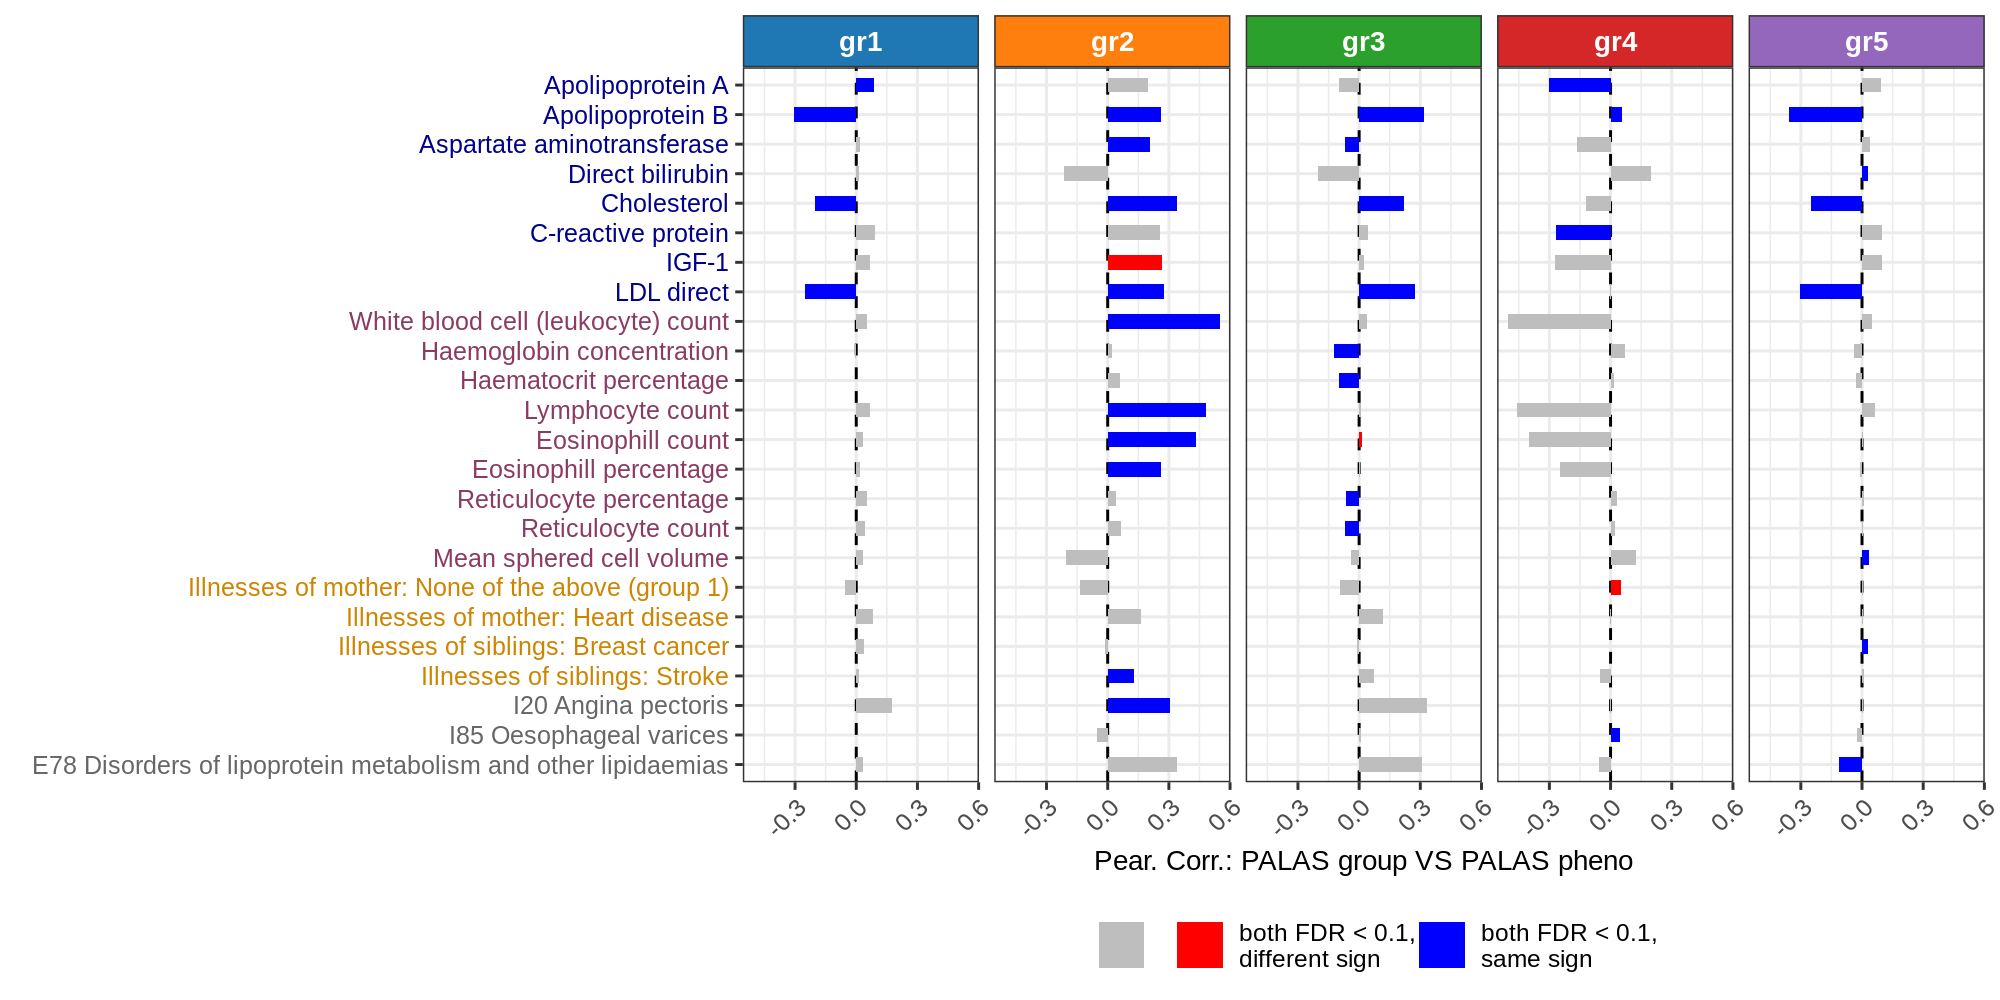

In [26]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)
corr_sign_pheno <- PALAScorr_forest_plot(colorFile, endop_tissue, corr_res, pval_pheno = 0.0001, pval_corr_thr = 0.1, outFold)
table(corr_sign_pheno$sign)
corr_sign_pheno[corr_sign_pheno$sign == "both FDR < 0.1,\ndifferent sign",]


The correlation is computed considering all pathways (not simply significant in a group of phenotype). It is computed among Z-statistics. We used both Reactome and GO combined.

We considered cluster-specific endophenotypes: 42 associations in total.
- We filtered for thos epathways for whcih we have a PALAS (40, Height and Non−accidental death in close genetic family removed). 
- Of this 40, 4 were only significant in the actual measurment: Eosin. perc. in gr3, LDL direct in gr4, Eosin. perc. in gr5 and mother heart disease in gr5. 
- Other 3 were significant in both but with an opposite association sign. Strongest was IGF-1 in gr2 (positive instead of negative, 0.27), Eosin. count in gr3 (0.01) and Ill. mother none of the above in gr4 (0.05)
- Everything else (33 associations) were significant in both actual endophenotype and PALAS correlation, with a concordant association sign.

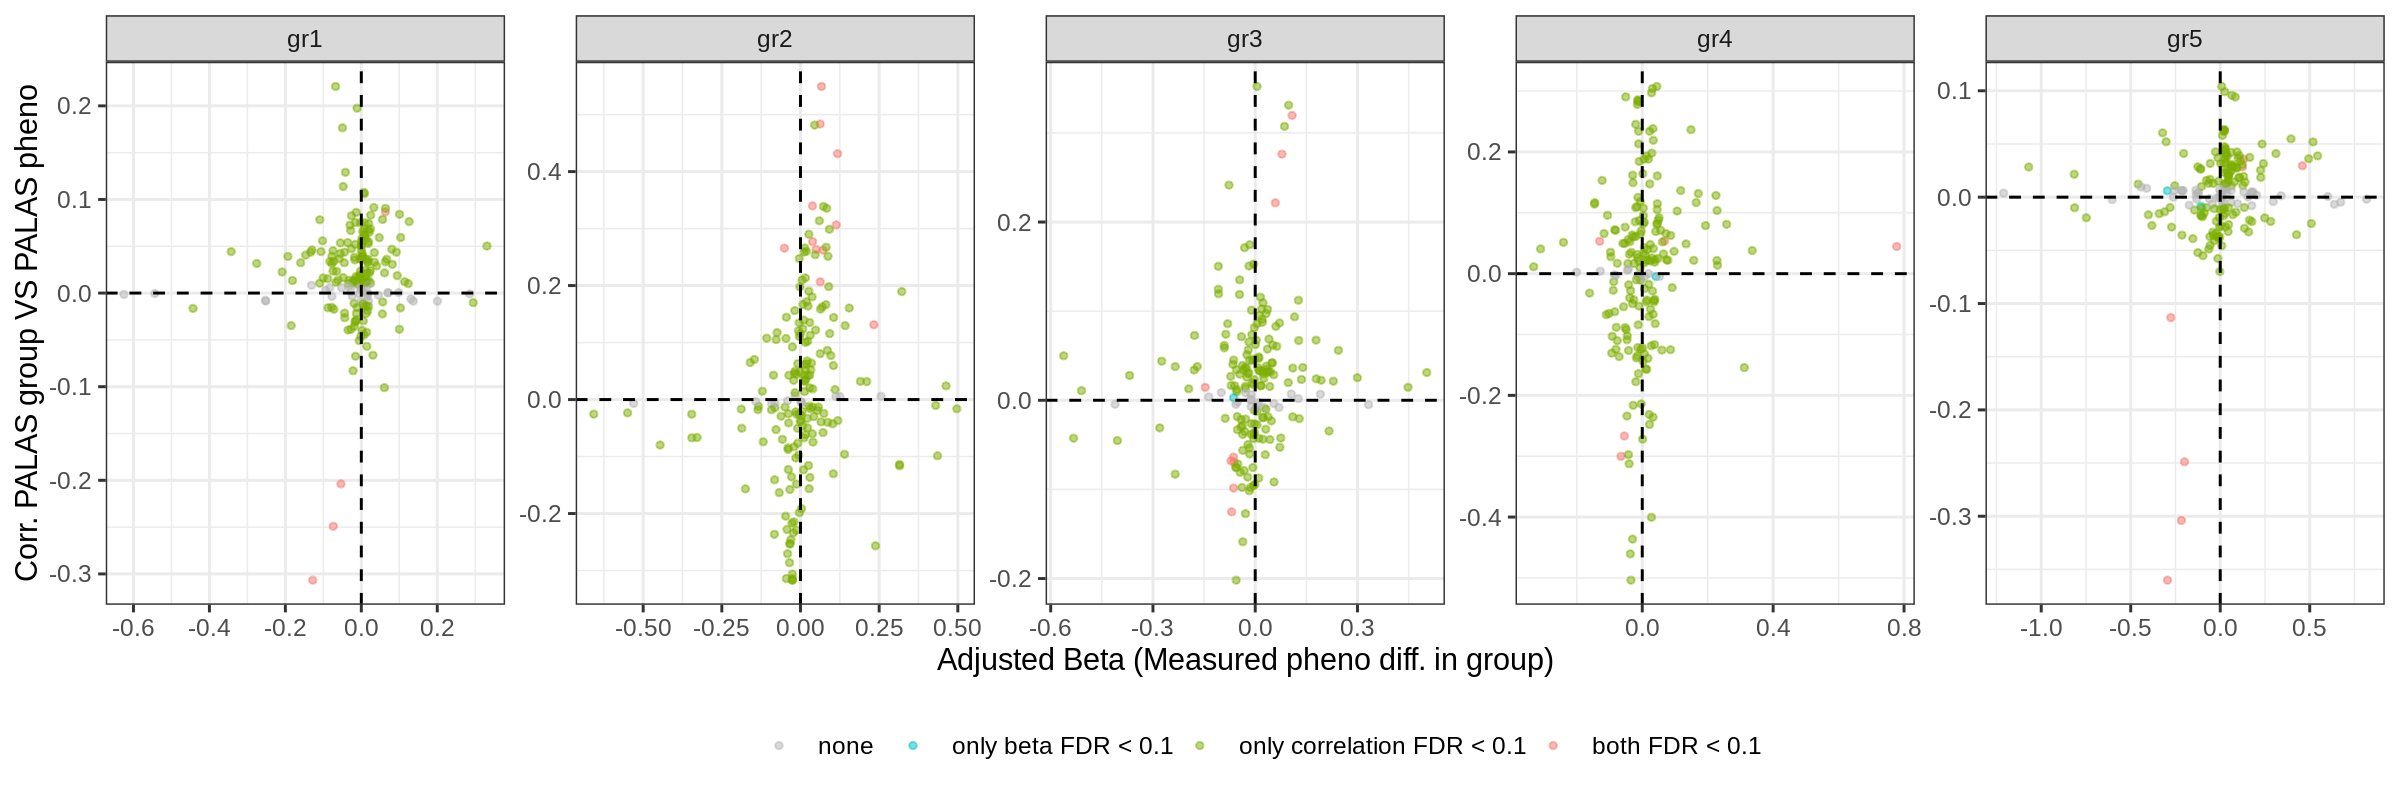

In [50]:
# scatter plot
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)

res_pheno = endop_tissue
corr_PALAS = corr_res
pval_corr_thr = 0.1

res_pheno$group <- sapply(as.character(res_pheno$comp), function(x) strsplit(x, split = '_vs_all')[[1]][1])
res_pheno$phenoid_groupid <- paste(res_pheno$pheno_id, res_pheno$group, sep = "_")
corr_PALAS$phenoid_groupid <- paste(corr_PALAS$pheno_id, corr_PALAS$group, sep = "_")

complete_df <- full_join(res_pheno, corr_PALAS, by = "phenoid_groupid", suffix = c("_pheno", "_PALAS")) %>%
    drop_na(group_PALAS) %>%
    filter(se_beta < 100) %>%
    mutate(res_sign = case_when(
       corr_pvalue_BH <= pval_corr_thr & pval_corr <= pval_corr_thr ~ "both FDR < 0.1",
        corr_pvalue_BH <= pval_corr_thr & pval_corr > pval_corr_thr  ~ "only correlation FDR < 0.1",
        corr_pvalue_BH > pval_corr_thr & pval_corr <= pval_corr_thr ~ "only beta FDR < 0.1",
        TRUE ~ "none"
    )) %>%
    mutate(res_sign = factor(res_sign, levels = c("none", "only beta FDR < 0.1", "only correlation FDR < 0.1", "both FDR < 0.1")))

hex <- hue_pal()(4)
pl <- ggplot(complete_df, aes(x = beta, y = corr, color = res_sign)) +
    geom_point(size = 0.9, alpha = 0.5) +
    facet_wrap(~group_PALAS, nrow = 1, scales = "free") +
    scale_color_manual(values = rev(c(hex[-length(hex)], "grey70"))) +
    geom_hline( yintercept = 0, linetype = "dashed", color = "black") +
    geom_vline( xintercept = 0, linetype = "dashed", color = "black") +
    theme_bw() +
    theme(legend.position = "bottom", legend.title = element_blank()) +
    xlab("Adjusted Beta (Measured pheno diff. in group)") + 
    ylab(sprintf("Corr. PALAS group VS PALAS pheno"))

pl


